# Data preparation

In [372]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
# from sklearn.mixture import GaussianMixture
import numpy as np

## Set path to folder with data

In [373]:
folder_path = Path('../data')

## Load patients info and check duplicates

In [374]:
# Check folder and file existence
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Directory {folder_path} does not exist.")

## Load time series data and combine and preprocess data

In [375]:
all_files = [folder_path / f for f in os.listdir(folder_path) if f.endswith('.csv')]
data_list = []
for file in all_files:
    temp_data = pd.read_csv(file, delimiter=';')
    temp_data['person_id'] = file.stem
    data_list.append(temp_data)

df = pd.concat(data_list, ignore_index=True).drop_duplicates()

## Convert time and handle errors

In [376]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.dropna(subset=['time'])
df['minute'] = df['time'].dt.minute
df['hour_of_day'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day.clip(1, df['time'].dt.days_in_month)
df.columns

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'person_id', 'minute',
       'hour_of_day', 'month', 'day'],
      dtype='object')

## Anomaly checks

In [377]:
# Heart rate check
df = df[(df['heart_rate'] > 40) & (df['heart_rate'] < 200)]
# Glucose range check
df = df[(df['glucose'] >= 0) & (df['glucose'] <= 500)]
# Minute range check
df = df[(df['minute'] >= 0) & (df['minute'] <= 59)]
# Hour of day range check
df = df[(df['hour_of_day'] >= 0) & (df['hour_of_day'] <= 23)]
# Month range check
df = df[(df['month'] >= 1) & (df['month'] <= 12)]
# Age range check

## Check target variable

In [378]:
if df['basal_rate'].isna().any():
    raise ValueError("Target variable 'basal_rate' contains missing values!")

## Analyse of data

In [379]:
df.head(8)

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,person_id,minute,hour_of_day,month,day
0,2018-09-19 14:25:00,90.041667,14.551950,70.521127,77.0,0.066667,0.0,0.0,HUPA0007P,25,14,9,19
1,2018-09-19 14:30:00,85.750000,17.323750,78.504202,62.0,0.066667,0.0,0.0,HUPA0007P,30,14,9,19
2,2018-09-19 14:35:00,81.458333,12.888870,73.060345,16.0,0.066667,0.0,0.0,HUPA0007P,35,14,9,19
3,2018-09-19 14:40:00,77.166667,16.769390,67.981481,79.0,0.066667,0.0,0.0,HUPA0007P,40,14,9,19
4,2018-09-19 14:45:00,72.875000,42.131361,92.503356,444.0,0.066667,0.0,0.0,HUPA0007P,45,14,9,19
5,2018-09-19 14:50:00,68.583333,49.060859,109.291667,459.0,0.066667,0.0,0.0,HUPA0007P,50,14,9,19
6,2018-09-19 14:55:00,64.291667,44.071620,101.888889,435.0,0.066667,0.0,0.0,HUPA0007P,55,14,9,19
7,2018-09-19 15:00:00,60.000000,14.136180,95.834711,9.0,0.066667,0.0,0.0,HUPA0007P,0,15,9,19


<Axes: >

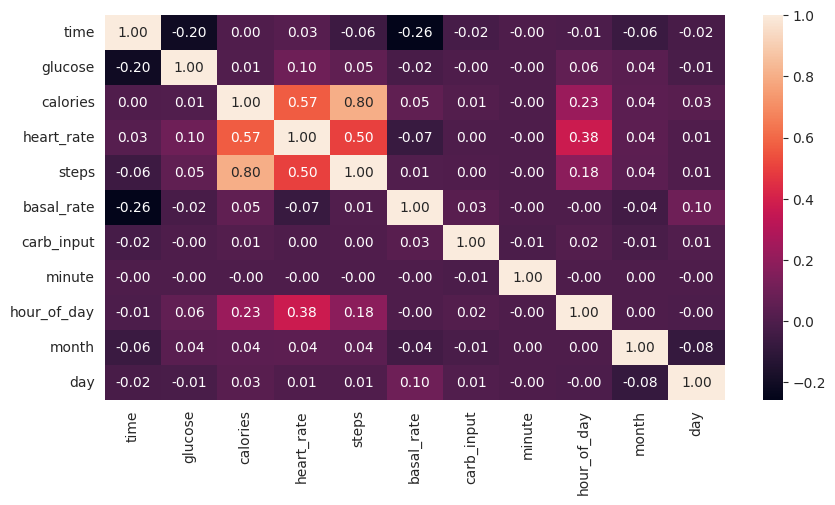

In [380]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.drop(columns=['bolus_volume_delivered', 'person_id']).corr(), annot=True, fmt='.2f')

## Define features

In [381]:
features = [
    'glucose', 'calories', 'heart_rate', 'steps',
    'bolus_volume_delivered', 'carb_input', 'minute',
    'hour_of_day', 'month', 'day',
]
print(features)

['glucose', 'calories', 'heart_rate', 'steps', 'bolus_volume_delivered', 'carb_input', 'minute', 'hour_of_day', 'month', 'day']


In [382]:
X = df[features]
y = df['basal_rate']

## Now calculating summary statistics for each of the columns

In [383]:
summary = df[features].describe().transpose()

# Predict dose

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data scaling

In [385]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## DT

### GMM

In [386]:
# # Train GMM for data augmentation
# n_components = 4  # Number of clusters (can experiment)
# gmm = GaussianMixture(n_components=n_components, random_state=42)
# gmm.fit(X_train_scaled)  # Train GMM on training data
#
# # Generate new data from trained model
# n_samples = 100  # Number of new samples we want to generate
# new_data = gmm.sample(n_samples=n_samples)[0]  # Generate new data. We take only the data array
# new_data_df = pd.DataFrame(new_data, columns=X_train.columns)  # Convert to DataFrame
#
# # Generating Labels for New Data Using Regression
# label_model = LinearRegression()
# label_model.fit(X_train_scaled, y_train)  # Обучаем на существующих данных
# new_labels = label_model.predict(new_data)
#
# # # Merge new data with original
# X_train_augmented = np.vstack([X_train_scaled, new_data])
# y_train_augmented = np.hstack([y_train, new_labels])
#
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_augmented, y_train_augmented)
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
# print(f'Decision Tree. R²: {r2_rounded}')
# print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

### Augmentation data (FOMA)

In [333]:
# def foma_augmentation(X, y, alpha=0.1, n_samples=100):
#     idx = np.random.choice(len(X), size=n_samples, replace=True)
#
#     X_selected = X[idx]
#     y_selected = y.iloc[idx].values
#
#     noise = alpha * np.random.randn(*X_selected.shape)
#     X_augmented = X_selected + noise
#
#     y_augmented = y_selected + alpha * np.random.randn(n_samples)
#
#     return np.vstack([X, X_augmented]), np.hstack([y, y_augmented])
#
#
# X_train_aug, y_train_aug = foma_augmentation(X_train_scaled, y_train)
#
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_aug, y_train_aug)
#
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# print(f'Decision Tree. Mean Squared Error: {round(mse, 6)}')
# print(f'Decision Tree. R²: {round(r2, 6)}')
# print(f'Decision Tree. Mean Absolute Error: {round(mae, 6)}')

### DT model creation, training and evaluation (with augmentation)

In [313]:
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_scaled, y_train)
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
# print(f'Decision Tree. R²: {r2_rounded}')
# print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

### DT model creation, training and evaluation (without augmentation)

In [314]:
# model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
# model.fit(X_train_scaled, y_train)
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
# print(f'Decision Tree. R²: {r2_rounded}')
# print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

## RF

### RF (FOMA) (with augmentation)

In [315]:
# def foma_augmentation(X, y, alpha=0.1, n_samples=100):
#     idx = np.random.choice(len(X), size=n_samples, replace=True)
#
#     X_selected = X[idx]
#     y_selected = y.iloc[idx].values
#
#     noise = alpha * np.random.randn(*X_selected.shape)
#     X_augmented = X_selected + noise
#
#     y_augmented = y_selected + alpha * np.random.randn(n_samples)
#
#     return np.vstack([X, X_augmented]), np.hstack([y, y_augmented])
#
#
# X_train_aug, y_train_aug = foma_augmentation(X_train_scaled, y_train)
#
# model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
# model.fit(X_train_aug, y_train_aug)
#
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# print(f'Random Forest. Mean Squared Error: {round(mse, 6)}')
# print(f'Random Forest. R²: {round(r2, 6)}')
# print(f'Random Forest. Mean Absolute Error: {round(mae, 6)}')

### RF (without augmentation)

In [316]:
    # model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
    # model.fit(X_train_scaled, y_train)
    #
    # # Prediction and model evaluation
    # y_pred = model.predict(X_test_scaled)
    #
    # mse = mean_squared_error(y_test, y_pred)
    # r2 = r2_score(y_test, y_pred)
    # mae = mean_absolute_error(y_test, y_pred)
    #
    # mse_rounded = round(mse, 6)
    # r2_rounded = round(r2, 6)
    # mae_rounded = round(mae, 6)
    #
    # # Output results
    # print(f'Random Forest. Mean Squared Error: {mse_rounded}')
    # print(f'Random Forest. R²: {r2_rounded}')
    # print(f'Random Forest. Mean Absolute Error: {mae_rounded}')